## Diversity Sampling of Wikipedia Articles

In [1]:
cd ../src

/workspace/diversity_sampling/src


In [2]:
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

In [4]:
import torch
torch.cuda.is_available()  # Code is faster on GPU !

True

In [26]:
from coreset import CoresetSampler
from plot import plot_dbscan_results, plot_coreset_results

### Retrieve data

In [7]:
df = pd.read_parquet('../output/df.parquet')
print(f"Retrieved {len(df)} articles")

Retrieved 486826 articles


In [13]:
embeds = np.load('../output/embeds.npy')
print(f"Embedding shape: {embed.shape}")

Embedding shape: (486826, 384)


### Coreset Sampler

In [14]:
EPS = 0.85  # Higher eps = bigger clusters
MIN_SAMPLES = 100
N_SAMPLES = 1000

In [15]:
coreset = CoresetSampler(
    n_samples=N_SAMPLES,
    initialization="dbscan",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=False,
    verbose=1,
)

### DBScan Initialization

In [16]:
%%time
init_ids = coreset.initialize(embeds)

Using cuml gpu-accelerated algorithms
Initializing with DBScan
[W] [15:23:09.023156] Batch size limited by the chosen integer type (4 bytes). 10895 -> 4411. Using the larger integer type might result in better performance
Initialize with 36 points
CPU times: user 1min 10s, sys: 890 ms, total: 1min 11s
Wall time: 1min 11s


In [17]:
y = coreset.dbscan_y
counts = np.bincount(y + 1)

In [18]:
print('Number of clusters :', len(counts) - 1)
print('Number of non-clustered prompts :', counts[0])

Number of clusters : 36
Number of non-clustered prompts : 460123


In [19]:
biggest = np.argsort(counts[1:])[::-1] # [:10]
sizes = np.sort(counts[1:])[::-1]
print('Biggest clusters :\t', list(biggest[:10]))
print('Associated sizes :\t', list(sizes[:10]))

Biggest clusters :	 [0, 4, 10, 28, 17, 18, 5, 6, 11, 15]
Associated sizes :	 [11717, 2601, 1610, 941, 837, 734, 681, 557, 503, 458]


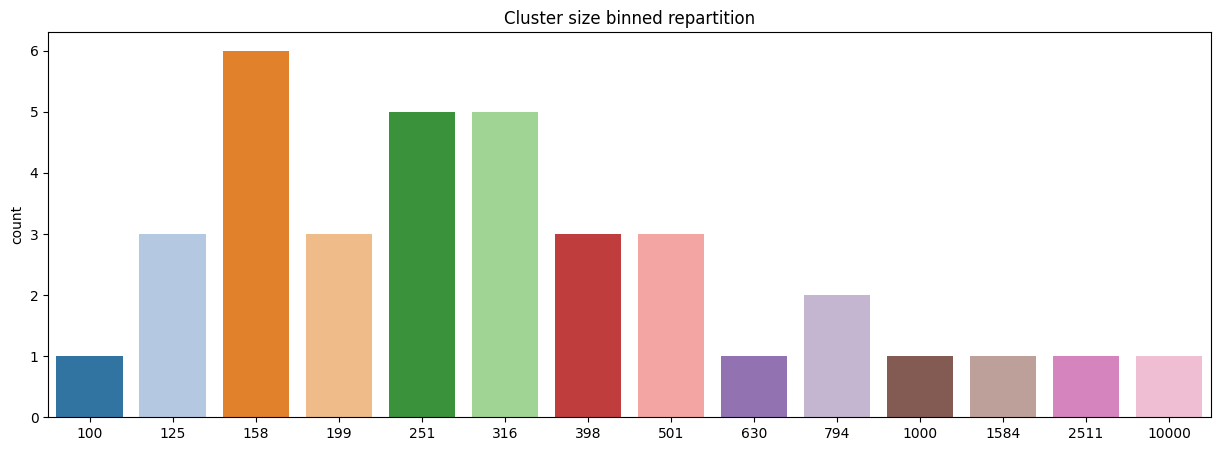

In [20]:
plt.figure(figsize=(15, 5))
sns.countplot(x=np.round(np.log10(np.clip(counts[1:], 0, 10000)), 1))
ticks, labels = plt.xticks()
labels = [float(l.get_text()) for l in labels]
plt.xticks(ticks, (10 ** np.array(labels)).astype(int))
plt.title('Cluster size binned repartition')
plt.show()

In [ ]:
plot_dbscan_results(embeds, y, counts, min_size=MIN_SAMPLES)

In [ ]:
for i, l in enumerate(np.argsort(counts)[::-1][:10]):
    l -= 1
    if l == -1:
        continue
        
    if counts[l + 1] <= MIN_SAMPLES:
        continue

    ids = np.where(y == l)[0]

    print("Cluster id :", l)
    print("Cluster size :", len(ids))
    display(df[['title', 'text']].iloc[ids].sample(5))  # min(5, len(ids))))

    print('-' * 100)

    # if i > 1:
    #     break

Cluster id : 0
Cluster size : 11717


,title,text
248175,Bowling at the 1995 Pan American Games,"This page shows the results of the Bowling Competition for men and women at the 1995 Pan American Games, held from March 11 to March 26, 1995, in Mar del Plata, Argentina. The event was included for the third time at the Pan American Games."
188337,María Luisa Souza,María Luisa Souza (born 21 November 1941) is a Mexican former freestyle swimmer. She competed at the 1960 Summer Olympics and the 1964 Summer Olympics.
6069,Cao Haiqing,Cao Haiqing (Chinese: 曹海清; born 28 September 1993 in Wuhan) is a Chinese footballer who plays for Cangzhou Mighty Lions in the Chinese Super League.
331204,Gmina Tarczyn,"Gmina Tarczyn is an urban-rural gmina (administrative district) in Piaseczno County, Masovian Voivodeship, in east-central Poland. Its seat is the town of Tarczyn, which lies approximately south-west of Piaseczno and south-west of Warsaw."
240433,Strzepcz,"Strzepcz (, , , ) is a village in the administrative district of Gmina Linia, within Wejherowo County, Pomeranian Voivodeship in northern Poland. It is approximately east of Linia, southwest of Wejherowo, and west of the regional capital Gdańsk. Its population is 766. For the region's history, see ""History of Pomerania"". It is home to Kashubian Secondary School.."


----------------------------------------------------------------------------------------------------
Cluster id : 4
Cluster size : 2601


,title,text
310706,Ângelo Taveira,Ângelo Rafael Oliveira Sousa Taveira (born 13 May 2000) is a Portuguese professional footballer who plays for Farense as a forward.
261991,"Javi Martínez (footballer, born 1997)",Javier Martínez Tabernero (born 10 May 1997) is a Spanish retired footballer who last played for Real Unión as a forward.
204085,Miguel Antonio Otero (born 1859),"Miguel Antonio Otero II (October 17, 1859 – August 7, 1944) was an American politician, businessman, and author who served as the 16th Governor of New Mexico Territory from 1897 to 1906. He was the son of Miguel Antonio Otero, a prominent businessman and New Mexico politician."
446409,Misael Alfaro,"Álvaro Misael Alfaro Sánchez (born January 6, 1971 in Nueva San Salvador, El Salvador) is a former Salvadoran professional goalkeeper and currently manager."
66096,Roberto Delgado (swimmer),"Roberto Delgado Martillo (born April 3, 1975) is an American-Ecuadorian former swimmer who specialized in freestyle and butterfly events. A two-time Olympian (1996 and 2000), he holds numerous Ecuadorian records in both 100 and 200 m butterfly, and retains his dual resident status to compete internationally for his parents' homeland. While studying in the United States, Delgado has been listed as an all-time Top 10 performer in the 200 m butterfly for the Arizona State Sun Devils."


----------------------------------------------------------------------------------------------------
Cluster id : 10
Cluster size : 1610


,title,text
302709,Traminda aventiaria,"Traminda aventiaria, the cross-line wave moth, is a moth of the family Geometridae. The species was first described by Achille Guenée in 1858. It is found in the Indian subregion, Sri Lanka, to Hong Kong, Taiwan, New Guinea and Australia."
152,Chrysodeixis acuta,"Chrysodeixis acuta, the tunbridge wells gem, is a moth of the family Noctuidae. It is found in Africa as well as the on Canary Islands eastwards to Australasia Indonesia and Oceania."
265266,Turuptiana obliqua,Turuptiana obliqua is a moth in the family Erebidae. It was described by Francis Walker in 1869. It is found in Mexico and Panama.
115465,Acosmetia caliginosa,"Acosmetia caliginosa, the reddish buff, is a moth of the family Noctuidae. The species was first described by Jacob Hübner in 1813. It is found throughout continental Europe and in southern Scandinavia. then east across the Palearctic to Siberia."
196931,Mythimna litoralis,"A strictly coastal species, it is found in Europe and Morocco in areas close to the shore. The wingspan is 36–42 mm. It is an ochre-colored moth having a distinctive white streak bordered with dark fine lines along the length of the forewing."


----------------------------------------------------------------------------------------------------
Cluster id : 28
Cluster size : 941


,title,text
263908,Pilsbryspira garciacubasi,"Pilsbryspira garciacubasi is a species of sea snail, a marine gastropod mollusk in the family Pseudomelatomidae, the turrids and allies."
239790,Conus granulatus,"Conus granulatus is a species of sea snail, a marine gastropod mollusk in the family Conidae, the cone snails and their allies."
353173,Hypselodoris yarae,"Hypselodoris yarae is a species of sea slug or dorid nudibranch, a marine gastropod mollusc in the family Chromodorididae."
133114,Doris tricolor,"Doris tricolor is a species of sea slug, a dorid nudibranch, a marine gastropod mollusc in the family Dorididae."
257440,Alloiodoris lanuginata,"Alloiodoris lanuginata is a species of sea slug or dorid nudibranch, a marine gastropod mollusk in the family Discodorididae."


----------------------------------------------------------------------------------------------------
Cluster id : 17
Cluster size : 837


,title,text
76211,WINL,"WINL (98.5 FM, ""Dixie Country"") is an American radio station licensed to serve the community of Linden, Alabama. The station's broadcast license is held by Westburg Broadcasting Alabama, LLC."
453926,KKCT,"KKCT (97.5 FM), known as Hot 97.5, is a Top 40 (CHR) radio station licensed to Bismarck, North Dakota."
304970,WZYZ,"WZYZ (90.1 FM) is a radio station licensed to Spencer, Tennessee, United States. The station is currently owned by Church Faith Trinity Assemblies."
294197,KSKR-FM,"KSKR-FM (100.9 FM) is an American radio station licensed to serve Sutherlin, Oregon, United States. The station, which began broadcasting in 1998, is currently owned by Brooke Communications, Inc."
466610,WFHG-FM,"WFHG-FM is a talk formatted broadcast radio station licensed to Bluff City, Tennessee and serving the Tri-Cities region of Tennessee and Virginia. WFHG is owned and operated by Bristol Broadcasting Company, Inc."


----------------------------------------------------------------------------------------------------
Cluster id : 18
Cluster size : 734


,title,text
256679,2015 Huntingdonshire District Council election,The 2015 Huntingdonshire District Council election took place on 7 May 2015 to elect members of Huntingdonshire District Council in England. This was on the same day as other local elections.
190599,2014 Basingstoke and Deane Borough Council election,The 2014 Basingstoke and Deane Borough Council election took place on 22 May 2014 to elect members of Basingstoke and Deane Borough Council in England. This was on the same day as other local elections. These elections were postponed from the usual first Thursday of May in order to coincide with the 2014 European Parliamentary Elections.
127854,Kai Hiu (constituency),"The constituency returns one district councillor to the Eastern District Council, with an election every four years."
166376,2009 Sligo County Council election,An election to Sligo County Council took place on 5 June 2009 as part of that year's Irish local elections. 25 councillors were elected from five electoral divisions by PR-STV voting for a five-year term of office.
38344,2007 Scarborough Borough Council election,The 2007 Scarborough Borough Council elections to the Scarborough Borough Council were held on 3 May 2007. The whole council was up for election and the Conservative party lost overall control of the council to no overall control. Overall turnout was 36%.


----------------------------------------------------------------------------------------------------
Cluster id : 5
Cluster size : 681


,title,text
242680,Sukumo Station,"Sukumo Station is a terminus of the Tosa Kuroshio Railway Sukumo Line, and is located 23.6 km from the opposing terminus of the line at"
119034,Fushiki Station,"Fushiki Station is served by the Himi Line, and is located 7.3 kilometers from the opposing end of the line at ."
200348,Minami-Arao Station,The station is served by the Kagoshima Main Line and is located 154.8 km from the starting point of the line at . Both local and rapid services on the line stop at the station.
340008,Kōnodai Station,"Kōnodai Station is served by the Keisei Main Line, and is located 16.4 km from the terminus of the line at Keisei-Ueno Station."
265490,Fudōin-mae Station,"Fudōin-mae Station is a HRT station on Astram Line, located in 3–3–12, Ushita-shinmachi, Naka-ku, Hiroshima."


----------------------------------------------------------------------------------------------------
Cluster id : 6
Cluster size : 557


,title,text
134673,"Karuppur, Kumbakonam","As per the 2001 census, Karuppur had a total population of 1468 with 741 males and 727 females. The sex ratio was 981. The literacy rate was 86.4"
460456,"Naganuma, Hokkaido","As of September 2016, the town has an estimated population of 11,262, and a density of 67 persons per km. The total area is 168.36 km."
37032,"Subramaniyapuram, Pudukkottai","census, Subramaniyapuram had a total population of 968 with 412 males and 556 females. Out of the total population 710 people were literate."
331827,Tallapalle,"India census, Tallapalle had a population of 10,937. Males constitute 52% of the population and females 48%. Tallapalle has an average literacy rate of 56%, lower than the national average of 59.5%: male literacy is 63%, and female literacy is 47%. In Tallapalle, 11% of the population is under 6 years of age."
242757,"Miyagi, Gunma","As of 2003, the village had an estimated population of 8,468 and a density of 175.87 persons per km². The total area was 48.15 km²."


----------------------------------------------------------------------------------------------------
Cluster id : 11
Cluster size : 503


,title,text
60104,Han Jin-su,Han Jin-su (born 16 December 1965) is a South Korean field hockey player. He competed in the men's tournament at the 1988 Summer Olympics.
103131,Hongman Choi,"Choi Hong-man (Korean: 최홍만, Hanja: 崔洪萬; born October 30, 1980), often anglicised to Hongman Choi, is a South Korean kickboxer, mixed martial artist, and former ssireum wrestler. In Asia, he is called ""Che Man"", ""Techno Goliath"", ""Korean Monster"" and ""Korean Colossus"". He won the 2005 K-1 Seoul Grand Prix beating Kaoklai Kaennorsing in the finals. He stands and weighs ."
376635,Lee Han-sol,Lee Han-sol (; born 23 August 1995) is a South Korean handball player for SK Sugar Gliders and the South Korean national team.
126295,Han Hyung-bae,"Han Hyung-bae (born March 21, 1976) is a field hockey player from South Korea, who was a member of the Men's National Team that won the silver medal at the 2000 Summer Olympics in Sydney. In the final the Asians were beaten by the title holders Netherlands after penalty strokes."
113209,Kim Ju-sik,"Kim Ju Sik (born September 25, 1992) is a North Korean pair skater. With his skating partner, Ryom Tae-ok, he is the 2018 Four Continents bronze medalist, the 2017 Asian Winter Games bronze medalist, 2016 Cup of Tyrol bronze medalist, and 2016 Asian Open Trophy champion."


----------------------------------------------------------------------------------------------------


### Sampling

In [24]:
ids = coreset.sample(embeds)

Use previously computed dbscan_y
Initialize with 36 points


100%|██████████| 964/964 [00:04<00:00, 195.02it/s]


In [ ]:
plot_coreset_results(embeds, y, counts, ids, min_size=MIN_SAMPLES)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [15:26:36.770767] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


## Compare with Random Sampling



In [28]:
n_texts = [100, 500, 1000, 2000, 3000, 4000, 5000]  # , 10000

In [29]:
coreset = CoresetSampler(
    initialization="",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=True,
    verbose=0,
)

In [30]:
diversities_coreset = []
kl_divs_coreset = []
for n in n_texts:
    diversities, kl_divs = [], []
    for _ in range(3):
        sampled_ids = coreset.sample(embeds, n_samples=n)
        df_s = df.iloc[sampled_ids].reset_index(drop=True)
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)

        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_coreset.append(div)
    kl_divs_coreset.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  -  KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.983  -  KL Divergence 0.332
- n=500 	-  Diversity: 0.861  -  KL Divergence 0.434
- n=1000 	-  Diversity: 0.741  -  KL Divergence 0.451
- n=2000 	-  Diversity: 0.596  -  KL Divergence 0.489
- n=3000 	-  Diversity: 0.483  -  KL Divergence 0.508
- n=4000 	-  Diversity: 0.414  -  KL Divergence 0.515
- n=5000 	-  Diversity: 0.361  -  KL Divergence 0.520


In [31]:
diversities_random = []
kl_divs_random = []
for n in n_texts:
    diversities = []
    kl_divs = []
    for _ in range(10):
        df_s = df.sample(n).reset_index(drop=True)
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)
                
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_random.append(div)
    kl_divs_random.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  - KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.890  - KL Divergence 0.469
- n=500 	-  Diversity: 0.672  - KL Divergence 0.677
- n=1000 	-  Diversity: 0.542  - KL Divergence 0.690
- n=2000 	-  Diversity: 0.409  - KL Divergence 0.720
- n=3000 	-  Diversity: 0.338  - KL Divergence 0.726
- n=4000 	-  Diversity: 0.292  - KL Divergence 0.734
- n=5000 	-  Diversity: 0.259  - KL Divergence 0.747


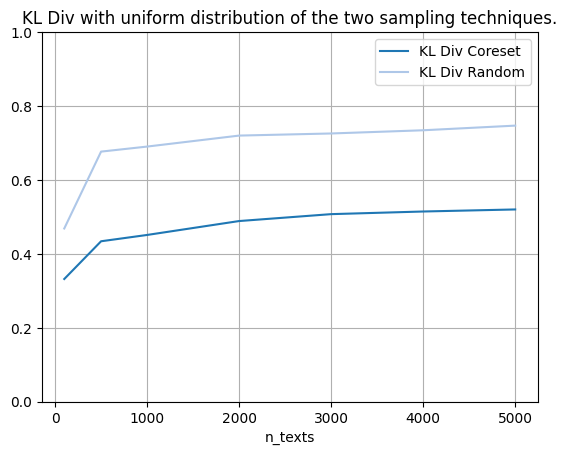

In [32]:
plt.plot(n_texts, kl_divs_coreset, label="KL Div Coreset")
plt.plot(n_texts, kl_divs_random, label="KL Div Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 1)
plt.grid()
plt.title('KL Div with uniform distribution of the two sampling techniques.')
plt.show()

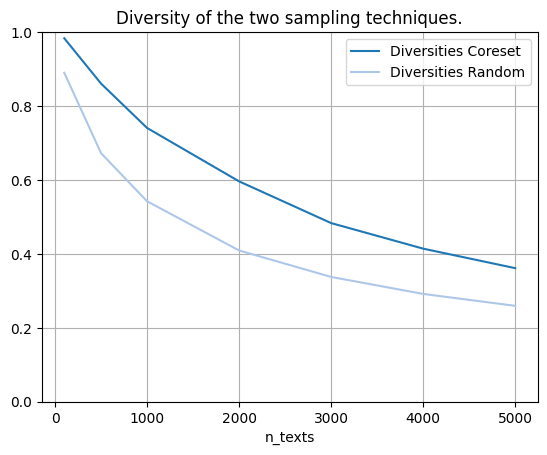

In [33]:
plt.plot(n_texts, diversities_coreset, label="Diversities Coreset")
plt.plot(n_texts, diversities_random, label="Diversities Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 1)
plt.grid()
plt.title('Diversity of the two sampling techniques.')
plt.show()

Done ! 